#Усложнение внутренней границы (многосеточный алгоритм)

Расчёт потенциала электрического поля вокруг спутника после размещения на кубсате мини-солнечных батарей (10 x 10) и штанги антенны (14 см, под углом 30 градусов, диаметром пренебречь).

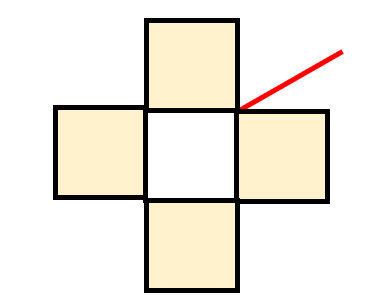

Алгоритм использует две сетки: одна с шагом 1 см (крупная), вторая с шагом 2 мм (мелкая, у поверхности спутника). Внешняя граница мелкой сетки на расстоянии 0,5 метра от спутника. При этом внутренние граничные узлы двух сеток будут совпадать везде, кроме штанги. Для нахождения значений в нерегулярных узлах применяется линейная интерполяция.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
field_size_large_grid = 100
number_of_nodes_large_grid = field_size_large_grid + 1
step_large_grid = 1

In [3]:
field_size_fine_grid = 100
number_of_nodes_fine_grid = field_size_large_grid * 5 + 1
step_fine_grid = field_size_fine_grid / (number_of_nodes_fine_grid - 1)

In [4]:
satellite_radius = 5

In [5]:
antenna_length = 14
angle = np.radians(60)

In [6]:
battery_size = 10

###Граничные условия

In [7]:
satellite_surface_potential = 10

###Создание сеток

In [8]:
U_coarse = np.zeros((number_of_nodes_large_grid, number_of_nodes_large_grid))
satellite_center_index_coarse = number_of_nodes_large_grid // 2

In [9]:
U_fine = np.zeros((number_of_nodes_fine_grid, number_of_nodes_fine_grid))
satellite_center_index_fine = number_of_nodes_fine_grid // 2

###Начальные координаты положения антенны

In [10]:
antenna_start_x_fine = satellite_center_index_fine + int(satellite_radius * (step_large_grid / step_fine_grid))
antenna_start_y_fine = satellite_center_index_fine + int(satellite_radius * (step_large_grid / step_fine_grid))

###Линейная интерполяция значений в нерегулярных узлах (в узлах расположения антенны)

In [11]:
def linear_interpolation(U_coarse, U_fine, step_large_grid, step_fine_grid, antenna_start_x, antenna_start_y, angle, antenna_length):
    for k in range(int(antenna_length / step_fine_grid)):

        i_fine = int(antenna_start_x + k * np.cos(angle))
        j_fine = int(antenna_start_y + k * np.sin(angle))

        if 0 < i_fine < number_of_nodes_fine_grid and 0 < j_fine < number_of_nodes_fine_grid:
            x_fine = i_fine * step_fine_grid
            y_fine = j_fine * step_fine_grid

            x_coarse = x_fine / step_large_grid
            y_coarse = y_fine / step_large_grid

            i_coarse = int(x_coarse)
            j_coarse = int(y_coarse)

            if i_coarse < number_of_nodes_large_grid - 1 and j_coarse < number_of_nodes_large_grid - 1:
                U_fine[i_fine, j_fine] = 0.25 * (U_coarse[i_coarse, j_coarse] + U_coarse[i_coarse + 1, j_coarse] +
                                                 U_coarse[i_coarse, j_coarse + 1] + U_coarse[i_coarse + 1, j_coarse + 1])

    return U_fine

###Расчёт потенциала

In [12]:
max_iter = 10000
accuracy = 1e-4

In [13]:
def is_circle_satellite(x, y, satellite_center, satellite_radius):
  inside_satellite_circle_radius = np.sqrt((i - satellite_center)**2 + (j - satellite_center)**2)

  return inside_satellite_circle_radius < satellite_radius

In [14]:
def square_area_side_distance(satellite_radius, satellite_center, satellite_surface_potential):
   square_area_side_distance = satellite_surface_potential * satellite_radius / np.sqrt(satellite_center * satellite_center + (i - satellite_radius) ** 2)

   return square_area_side_distance

In [15]:
def is_square_satellite_surface(x, y, satellite_center, satellite_radius):
  y_distance = abs(i - satellite_center)
  x_distance = abs(j - satellite_center)

  return y_distance == satellite_radius or x_distance == satellite_radius

In [16]:
def find_potential_around_antenna(satellite_center, satellite_radius, antenna_length, angle, satellite_surface_potential, U_coarse):
  antenna_start_x = satellite_center + satellite_radius
  antenna_start_y = satellite_center + satellite_radius

  for k in range(int(antenna_length / step_large_grid)):
      i = int(antenna_start_x + k * np.cos(angle))
      j = int(antenna_start_y + k * np.sin(angle))

      if 0 <= i < number_of_nodes_large_grid and 0 <= j < number_of_nodes_large_grid:
            U_coarse[i, j] = satellite_surface_potential

  return U_coarse

In [17]:
def find_potential_around_right_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse):
  for i in range(satellite_center_index_coarse - satellite_radius, satellite_center_index_coarse + satellite_radius + 1):
        for j in range(satellite_center_index_coarse + satellite_radius + 1, satellite_center_index_coarse + satellite_radius + battery_size + 1):
            if abs(i - satellite_center_index_coarse) == satellite_radius or abs(j - (satellite_center_index_coarse + battery_size)) == satellite_radius:
                U_coarse[i,j] = satellite_surface_potential
            else:
                U_coarse[i,j] = 0

  return U_coarse

In [18]:
def find_potential_around_left_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse):
  for i in range(satellite_center_index_coarse - satellite_radius, satellite_center_index_coarse + satellite_radius + 1):
        for j in range(satellite_center_index_coarse - satellite_radius - battery_size,  satellite_center_index_coarse - satellite_radius):
            if abs(i - satellite_center_index_coarse) == satellite_radius or abs(j - (satellite_center_index_coarse - battery_size)) == satellite_radius:
                U_coarse[i,j] = satellite_surface_potential
            else:
                U_coarse[i,j] = 0

  return U_coarse

In [19]:
def find_potential_around_bottom_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse):
  for i in range(satellite_center_index_coarse - satellite_radius - battery_size, satellite_center_index_coarse - satellite_radius):
        for j in range(satellite_center_index_coarse - satellite_radius, satellite_center_index_coarse + satellite_radius + 1):
            if abs(i - (satellite_center_index_coarse - battery_size)) == satellite_radius or abs(j - satellite_center_index_coarse) == satellite_radius:
                U_coarse[i,j] = satellite_surface_potential
            else:
                U_coarse[i,j] = 0

  return U_coarse

In [20]:
def find_potential_around_top_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse):
  for i in range(satellite_center_index_coarse + satellite_radius, satellite_center_index_coarse + satellite_radius + battery_size + 1):
        for j in range(satellite_center_index_coarse - satellite_radius, satellite_center_index_coarse + satellite_radius + 1):
            if abs(i - (satellite_center_index_coarse + battery_size)) == satellite_radius or abs(j - satellite_center_index_coarse) == satellite_radius:
                U_coarse[i,j] = satellite_surface_potential
            else:
                U_coarse[i,j] = 0

  return U_coarse

In [21]:
for iteration in range(max_iter):
    U_prev = U_coarse.copy()

    for i in range(1, number_of_nodes_large_grid - 1):
        for j in range(1, number_of_nodes_large_grid - 1):
            if is_circle_satellite(j, i, satellite_center_index_coarse, satellite_radius):
                pass
            else:
                U_coarse[i, j] = 0.25 * (U_prev[i + 1, j] + U_prev[i - 1, j] +
                                  U_prev[i, j + 1] + U_prev[i, j - 1])

    for i in range(satellite_center_index_coarse - satellite_radius, satellite_center_index_coarse + satellite_radius + 1):
        for j in range(satellite_center_index_coarse - satellite_radius, satellite_center_index_coarse + satellite_radius + 1):
            if is_square_satellite_surface(j, i, satellite_center_index_coarse, satellite_radius):
                U_coarse[i, j] = satellite_surface_potential
            else:
                U_coarse[i, j] = 0

    U_coarse = find_potential_around_antenna(satellite_center_index_coarse, satellite_radius, antenna_length, angle, satellite_surface_potential, U_coarse)

    U_coarse = find_potential_around_right_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse)

    U_coarse = find_potential_around_left_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse)

    U_coarse = find_potential_around_bottom_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse)

    U_coarse = find_potential_around_top_battery(satellite_center_index_coarse, satellite_radius, battery_size, satellite_surface_potential, U_coarse)

    for i in range(number_of_nodes_large_grid):
        U_coarse[0, i] = U_coarse[number_of_nodes_large_grid-1, i] = U_coarse[i, 0] = U_coarse[i, number_of_nodes_large_grid-1] = satellite_radius * satellite_surface_potential / np.sqrt(satellite_center_index_coarse * satellite_center_index_coarse + (i - satellite_center_index_coarse) ** 2)

    if np.max(np.abs(U_coarse - U_prev)) < accuracy:
        print(f"Требуется {iteration} итераций")
        break

Требуется 3095 итераций


###Нахождение значений в нерегулярных узлах

In [22]:
U_fine_antenna = linear_interpolation(U_coarse, np.zeros_like(U_fine), step_large_grid, step_fine_grid, antenna_start_x_fine, antenna_start_y_fine, angle, antenna_length)

###Перенос данных с крупной сетки на мелкую

In [23]:
for i in range(number_of_nodes_fine_grid):
    for j in range(number_of_nodes_fine_grid):
        x_coarse = i * step_fine_grid / step_large_grid
        y_coarse = j * step_fine_grid / step_large_grid

        if 0 <= x_coarse < number_of_nodes_fine_grid and 0 <= y_coarse < number_of_nodes_fine_grid:
            U_fine[i, j] = U_coarse[int(x_coarse), int(y_coarse)]

###Объединение значений в регулярных и нерегулярных узлах

In [24]:
U_fine_combined = np.where(U_fine_antenna != 0, U_fine_antenna, U_fine)

###Визуализация

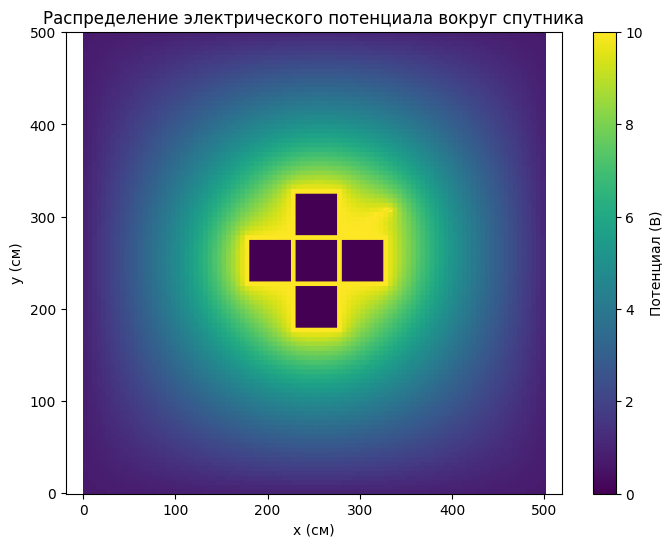

In [25]:
plt.figure(figsize=(8, 6))
plt.imshow(U_fine_combined)
plt.colorbar(label='Потенциал (В)')
plt.title('Распределение электрического потенциала вокруг спутника')
plt.xlabel('x (см)')
plt.ylabel('y (см)')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()